In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('world_tourism_economy_data.csv')

In [3]:
df.shape

(6650, 11)

In [4]:
df.dtypes

country                  object
country_code             object
year                      int64
tourism_receipts        float64
tourism_arrivals        float64
tourism_exports         float64
tourism_departures      float64
tourism_expenditures    float64
gdp                     float64
inflation               float64
unemployment            float64
dtype: object

In [5]:
df.isna().sum()

country                    0
country_code               0
year                       0
tourism_receipts        2361
tourism_arrivals        1701
tourism_exports         2536
tourism_departures      4061
tourism_expenditures    2477
gdp                      226
inflation                982
unemployment            2992
dtype: int64

In [6]:
df.head()

,country,country_code,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment
0,Aruba,ABW,1999,7.820000e+08,9.720000e+05,62.542949,NaN,9.495387,1.722905e+09,2.280372,NaN
1,Africa Eastern and Southern,AFE,1999,8.034209e+09,1.530938e+07,12.204030,NaN,7.760536,2.654290e+11,7.819865,NaN
2,Afghanistan,AFG,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,1999,1.443613e+09,3.897975e+06,3.974476,NaN,6.147291,1.394680e+11,0.372266,NaN
4,Angola,AGO,1999,3.100000e+07,4.500000e+04,0.583858,NaN,2.489638,6.152923e+09,248.195902,NaN


In [7]:
df = df.drop('country_code', axis=1)

In [8]:
numerical_cols = ['tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_departures', 'tourism_expenditures', 'gdp', 'inflation', 'unemployment']

In [9]:
# Group by country and then fill missing values using forward-fill and backward-fill
for col in numerical_cols:
    df[col] = df.groupby('country')[col].transform(lambda x: x.ffill().bfill())

In [10]:
# For any remaining NaN values (for countries with no data at all), fill with the global median
for col in numerical_cols:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)


In [11]:
# Feature Engineering
df['travel_balance'] = df['tourism_receipts'] - df['tourism_expenditures']
df['receipts_per_arrival'] = df['tourism_receipts'] / df['tourism_arrivals']

In [12]:
# Handle potential division by zero or NaN values in 'receipts_per_arrival'
df['receipts_per_arrival'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['receipts_per_arrival'].fillna(0, inplace=True)


In [13]:
df.head()

,country,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment,travel_balance,receipts_per_arrival
0,Aruba,1999,7.820000e+08,9.720000e+05,62.542949,3388000.0,9.495387,1.722905e+09,2.280372,6.920000,7.820000e+08,804.526749
1,Africa Eastern and Southern,1999,8.034209e+09,1.530938e+07,12.204030,3388000.0,7.760536,2.654290e+11,7.819865,6.444029,8.034209e+09,524.790046
2,Afghanistan,1999,5.700000e+07,2.077000e+06,3.074576,3388000.0,1.018339,3.521418e+09,12.686269,2.495000,5.700000e+07,27.443428
3,Africa Western and Central,1999,1.443613e+09,3.897975e+06,3.974476,3388000.0,6.147291,1.394680e+11,0.372266,4.368328,1.443613e+09,370.349434
4,Angola,1999,3.100000e+07,4.500000e+04,0.583858,3388000.0,2.489638,6.152923e+09,248.195902,23.643000,3.100000e+07,688.888889


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               6650 non-null   object 
 1   year                  6650 non-null   int64  
 2   tourism_receipts      6650 non-null   float64
 3   tourism_arrivals      6650 non-null   float64
 4   tourism_exports       6650 non-null   float64
 5   tourism_departures    6650 non-null   float64
 6   tourism_expenditures  6650 non-null   float64
 7   gdp                   6650 non-null   float64
 8   inflation             6650 non-null   float64
 9   unemployment          6650 non-null   float64
 10  travel_balance        6650 non-null   float64
 11  receipts_per_arrival  6650 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 623.6+ KB


In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [16]:
# Separate features and target variable. For now, we'll preprocess all columns.
# We are not defining a target variable yet, as the goal is to preprocess the data.
X = df

In [17]:
# Identify categorical and numerical features
categorical_features = ['country']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()


In [20]:
# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')


In [21]:
# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


In [22]:
# Fit and transform the data
X_processed = preprocessor.fit_transform(X)


In [23]:
# The output 'X_processed' is a sparse matrix. For displaying purposes, we convert it to a dense array.
# For large datasets, it's better to keep it as a sparse matrix.
# We also need to get the new column names after one-hot encoding.
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)


In [24]:
# Create a new DataFrame with the processed data
df_processed = pd.DataFrame(X_processed.toarray(), columns=all_feature_names)


In [25]:
# Save the processed data to a new CSV file
df_processed.to_csv('world_tourism_economy_data_processed.csv', index=False)

In [26]:
print("Preprocessing is complete!")
print("The processed data has been saved to 'world_tourism_economy_data_processed.csv'.")
print("Here are the first 5 rows of the processed data:")
df_processed.head()

Preprocessing is complete!
The processed data has been saved to 'world_tourism_economy_data_processed.csv'.
Here are the first 5 rows of the processed data:


,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment,travel_balance,...,country_Uzbekistan,country_Vanuatu,"country_Venezuela, RB",country_Viet Nam,country_Virgin Islands (U.S.),country_West Bank and Gaza,country_World,"country_Yemen, Rep.",country_Zambia,country_Zimbabwe
0,-1.664101,-0.202742,-0.282426,2.650293,-0.24942,0.795167,-0.264298,-0.209456,-0.171466,-0.202742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.664101,-0.144248,-0.212757,-0.152947,-0.24942,0.345600,-0.229770,0.078471,-0.252298,-0.144248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.664101,-0.208590,-0.277057,-0.661342,-0.24942,-1.401563,-0.264062,0.331413,-0.922948,-0.208590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.664101,-0.197406,-0.268208,-0.611229,-0.24942,-0.072454,-0.246262,-0.308634,-0.604807,-0.197406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.664101,-0.208799,-0.286931,-0.800044,-0.24942,-1.020293,-0.263718,12.572551,2.668542,-0.208799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df_processed.shape

(6650, 277)

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
inertia = []
silhouette_scores = []
K_range = range(2, 11) # We will test K from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_processed)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_processed, kmeans.labels_))


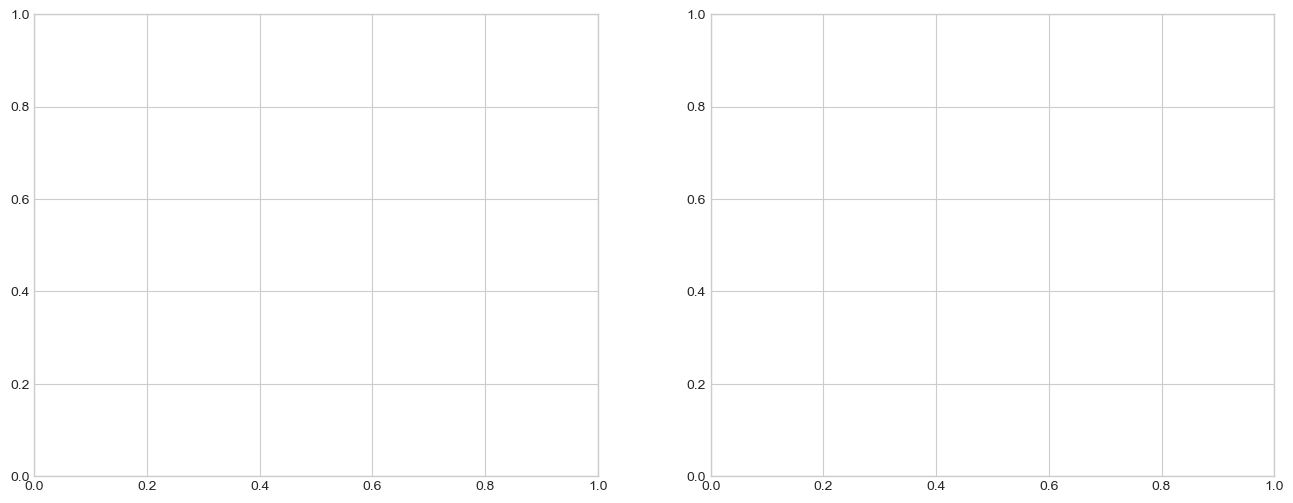

In [33]:
# --- Plotting the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

In [34]:
# Elbow Method Plot
ax1.plot(K_range, inertia, 'bo-')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True)

# Silhouette Score Plot
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Optimal K')
ax2.grid(True)

plt.suptitle('Model Evaluation to Determine Optimal K', fontsize=16)
plt.show()

<Figure size 640x480 with 0 Axes>

In [35]:
from sklearn.decomposition import PCA

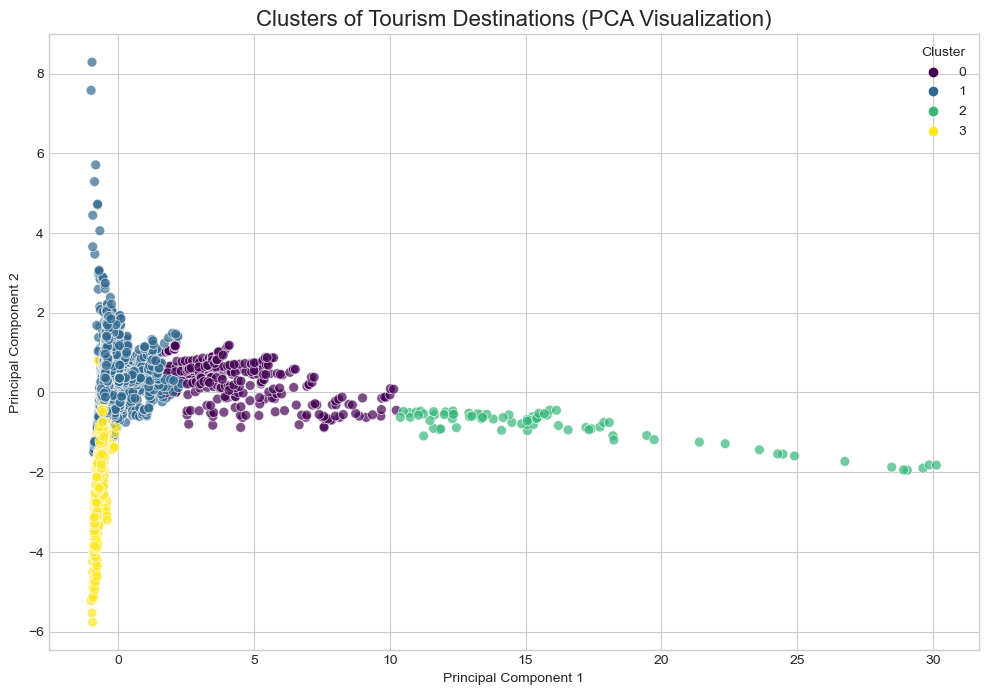

In [36]:
# --- Apply K-Means with the optimal K ---
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(df_processed)

# --- Use PCA for Dimensionality Reduction & Visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_processed)

# Create a DataFrame with PCA results and cluster labels
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = cluster_labels

# --- Plot the PCA scatter plot of clusters ---
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters of Tourism Destinations (PCA Visualization)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [37]:
df_original = pd.read_csv('world_tourism_economy_data.csv')

In [38]:
# Clean the original data in the same way as before for accurate analysis
df_original = df_original.drop('country_code', axis=1)
numerical_cols = ['tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_departures', 'tourism_expenditures', 'gdp', 'inflation', 'unemployment']
for col in numerical_cols:
    df_original[col] = df_original.groupby('country')[col].transform(lambda x: x.ffill().bfill())
for col in numerical_cols:
    median_val = df_original[col].median()
    df_original[col].fillna(median_val, inplace=True)

# Feature Engineering
df_original['travel_balance'] = df['tourism_receipts'] - df['tourism_expenditures']
df_original['receipts_per_arrival'] = df['tourism_receipts'] / df['tourism_arrivals']

# Handle potential division by zero or NaN values in 'receipts_per_arrival'
df['receipts_per_arrival'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['receipts_per_arrival'].fillna(0, inplace=True)

# Add the cluster labels to this cleaned, non-scaled dataframe
df_original['Cluster'] = cluster_labels

# Calculate the mean of key features for each cluster
cluster_interpretation = df_original.groupby('Cluster')[['tourism_receipts', 'tourism_arrivals', 'gdp', 'receipts_per_arrival', 'travel_balance', 'unemployment']].mean().sort_values(by='gdp', ascending=False)

# To make the numbers more readable, format them
pd.options.display.float_format = '{:,.2f}'.format
print("Cluster Profiles based on Average Characteristics:")
cluster_interpretation

Cluster Profiles based on Average Characteristics:


,tourism_receipts,tourism_arrivals,gdp,receipts_per_arrival,travel_balance,unemployment
Cluster,,,,,,
2,"1,005,182,181,818.18","1,430,104,576.61","56,088,663,636,363.63",696.67,"1,005,182,181,812.42",6.31
0,"160,666,479,020.98","598,750,486.81","20,081,381,643,356.64",313.78,"160,666,479,015.50",6.40
1,"9,136,147,803.59","21,216,483.04","657,258,150,236.19",957.90,"9,136,147,798.24",7.68
3,"2,127,038,471.05","3,109,378.40","25,973,996,767.22","1,140.95","2,127,038,459.84",9.47


In [39]:
# Let's see some example countries in each cluster
print("\n--- Example Destinations in Each Cluster ---")
for i in range(4):
    countries = df_original[df_original['Cluster'] == i]['country'].unique()
    # To keep it concise, show up to 5 examples
    example_countries = list(countries)[:5]
    print(f"\nCluster {i}:")
    print(", ".join(example_countries))


--- Example Destinations in Each Cluster ---

Cluster 0:
Europe & Central Asia, Euro area, European Union, High income, IDA & IBRD total

Cluster 1:
Africa Eastern and Southern, Afghanistan, Africa Western and Central, Angola, Arab World

Cluster 2:
World, High income, OECD members, Post-demographic dividend

Cluster 3:
Aruba, Albania, Andorra, Argentina, Antigua and Barbuda
